In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [41]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100000

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

In [19]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [20]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu, input_size):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear(input_size, 128, bias=False),
            nn.LeakyReLU(0.2),

            nn.Linear(128, 128, bias=False),
            nn.LeakyReLU(0.2),
            
            nn.Linear(128, 128, bias=False),
            nn.LeakyReLU(0.2),
            
            nn.Linear(128, 128, bias=False),
            nn.LeakyReLU(0.2),
            
            nn.Linear(128, 6, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [21]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [22]:
ngpu

0

In [23]:
# Create the generator
netG = Generator(ngpu, 50).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=50, out_features=128, bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=128, bias=False)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=128, bias=False)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=128, out_features=128, bias=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=128, out_features=6, bias=False)
    (9): Sigmoid()
  )
)


In [24]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, input_size):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear(input_size, 128, bias=False),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),

            nn.Linear(128, 128, bias=False),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            
            nn.Linear(128, 128, bias=False),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            
            nn.Linear(128, 128, bias=False),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            
            nn.Linear(128, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [25]:
# Create the Discriminator
netD = Discriminator(ngpu, 2).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=128, out_features=128, bias=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=128, out_features=1, bias=False)
    (13): Sigmoid()
  )
)


In [26]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 50, device=device)
print(fixed_noise.shape)
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

torch.Size([64, 50])


In [27]:
from data_prep_torch import u_v_model, gen_events, get_dsigma1, get_dsigma2, wrapperGenerator, paramsToEvents
from scipy.special import gamma

In [28]:
# outputDirectory = "/work/data_science/kishan/Theory/Experiments_0/"
beta=lambda a,b: gamma(a)*gamma(b)/gamma(a+b)

au=-0.5; bu=3; nu=2/beta(au+1,bu+1)
ad=-0.5; bd=4; nd=1/beta(au+1,bu+1)
truth_par=np.array([nu,au,bu,nd,ad,bd])
print("Ground Truth parameters: ", truth_par)

Ground Truth parameters:  [ 2.1875  -0.5      3.       1.09375 -0.5      4.     ]


In [29]:
truth = np.array([[2.1875, -0.5, 3, 1.09375, -0.5, 4],
                 [2.1875, -0.5, 3, 1.09375, -0.5, 4]]).astype(np.float32)
parmin = np.array([0.0, -1.0, 0.0, 0.0, -1.0, 0.0]).astype(np.float32)
parmax = np.array([3.0, 1.0, 5.0, 3.0, 1.0, 5.0]).astype(np.float32)

def normalize_pars(t, parmin, parmax):
    return (t - parmin) / (parmax - parmin)

truth_scaled = normalize_pars(truth, parmin, parmax)
truth_scaled = torch.from_numpy(truth_scaled)
parmin = torch.from_numpy(parmin)
parmax = torch.from_numpy(parmax)
print(truth_scaled)
train_events, train_norm1, train_norm2 = wrapperGenerator(truth_scaled, parmin, parmax, 100000)
train_events = train_events[0]
train_norm1 = train_norm1[0]
train_norm2 = train_norm2[0]

tensor([[0.7292, 0.2500, 0.6000, 0.3646, 0.2500, 0.8000],
        [0.7292, 0.2500, 0.6000, 0.3646, 0.2500, 0.8000]])


In [30]:
train_events.shape

torch.Size([2, 100000])

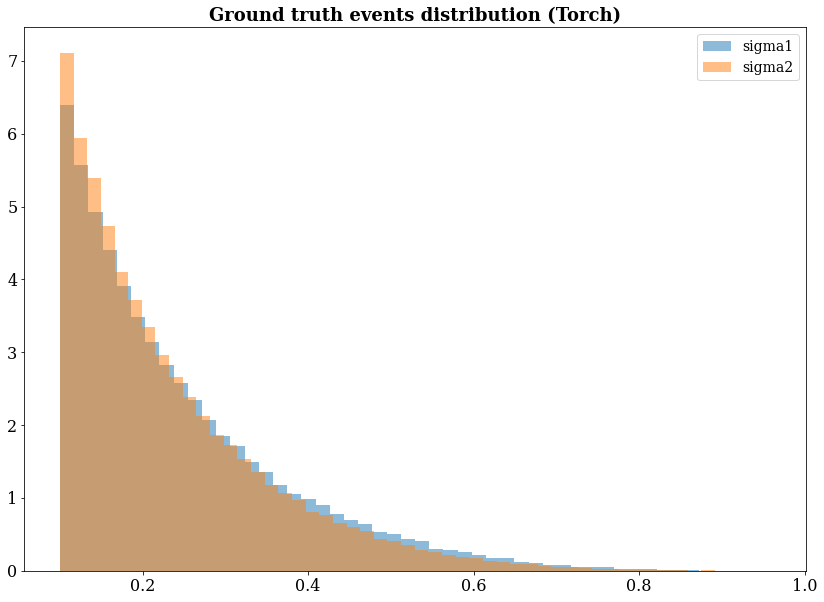

In [31]:
heights11, _, _ = plt.hist(train_events[0].numpy(), bins=50, alpha=0.5, label="sigma1", density=True)
heights12, _, _ = plt.hist(train_events[1].numpy(), bins=50, alpha=0.5, label="sigma2", density=True)
plt.title("Ground truth events distribution (Torch)")
plt.legend()
plt.show()

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    
    indices = np.random.randint(0, train_events.shape[1], 64)
    data = np.transpose(train_events[:, indices])
    noise = torch.randn(b_size, 50, device=device)
    parmin = parmin.to(device)
    parmax = parmax.to(device)

    netD.zero_grad()
    real_cpu = data.to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

    # Forward pass real batch through D
    output = netD(real_cpu).view(-1)
    errD_real = criterion(output, label)
    errD_real.backward(retain_graph=True)

    fake = netG(noise)
    label.fill_(fake_label)
    events, norm1, norm2 = wrapperGenerator(fake, parmin, parmax, 1)
    events = torch.squeeze(events)
    output = netD(events).view(-1)
    errD_fake = criterion(output, label)
    errD_fake.backward(retain_graph=True)
    errD = errD_real + errD_fake
    optimizerD.step()


    # (2) Update G network: maximize log(D(G(z)))    
    netG.zero_grad()
    label.fill_(real_label)  
    events, norm1, norm2 = wrapperGenerator(fake, parmin, parmax, 1)
    events = torch.squeeze(events)
    output = netD(events).view(-1)
    errG = criterion(output, label)
    errG.backward()
    optimizerG.step()

    # Output training stats
    if iters % 50 == 0:
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
              % (epoch, num_epochs,
                 errD.item(), errG.item()))

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    iters += 1

Starting Training Loop...
[0/100000]	Loss_D: 1.3846	Loss_G: 0.7052
[50/100000]	Loss_D: 1.3872	Loss_G: 0.6972
[100/100000]	Loss_D: 1.3877	Loss_G: 0.6869
[150/100000]	Loss_D: 1.3880	Loss_G: 0.6944
[200/100000]	Loss_D: 1.3859	Loss_G: 0.6970
[250/100000]	Loss_D: 1.3861	Loss_G: 0.6812
[300/100000]	Loss_D: 1.3881	Loss_G: 0.7013
[350/100000]	Loss_D: 1.3870	Loss_G: 0.6884
[400/100000]	Loss_D: 1.3864	Loss_G: 0.6853
[450/100000]	Loss_D: 1.3857	Loss_G: 0.7027
[500/100000]	Loss_D: 1.3863	Loss_G: 0.6949
[550/100000]	Loss_D: 1.3863	Loss_G: 0.6872
[600/100000]	Loss_D: 1.3870	Loss_G: 0.6960
[650/100000]	Loss_D: 1.3860	Loss_G: 0.6903
[700/100000]	Loss_D: 1.3856	Loss_G: 0.6889
[750/100000]	Loss_D: 1.3853	Loss_G: 0.6863
[800/100000]	Loss_D: 1.3858	Loss_G: 0.7071
[850/100000]	Loss_D: 1.3845	Loss_G: 0.6819
[900/100000]	Loss_D: 1.3883	Loss_G: 0.7049
[950/100000]	Loss_D: 1.3863	Loss_G: 0.6822
[1000/100000]	Loss_D: 1.3851	Loss_G: 0.7091
[1050/100000]	Loss_D: 1.3848	Loss_G: 0.6845
[1100/100000]	Loss_D: 1.3888	